## Malware Detection Using CNNs


In [2]:
import os
import numpy as np
from PIL import Image

**Data Processing**

In [4]:
def binary_file_to_image(filepath, size=(64, 64)):
    #open file and read binary  data
    with open(filepath, 'rb') as fname:
        byte_arr = np.frombuffer(fname.read(), dtype=np.uint8)
    
    # Flatten or pad the array to fit the target image size
    desired_size = size[0] * size[1]
    # Trucate if file size is too large
    if len(byte_arr) > desired_size:
        byte_arr = byte_arr[:desired_size]
    #Pad with zeros if file size is too small
    else:
        byte_arr = np.pad(byte_arr, (0, desired_size - len(byte_arr)), 'constant', constant_values=0)
    # returns image
    image = byte_arr.reshape(size)
    return image

In [5]:
#Define function to load the data set from the folders
def load_dataset(folder_path, size=(64, 64)): 
    # List X  to hold features and list Y variable holds class labels
    X, y = [], []
    for label, subfolder in enumerate(['ben', 'mal']):
        # prepares the subfolders 
        class_folder = os.path.join(folder_path, subfolder)
        for file_name in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file_name)
        # Calls previous function to convert data to grayscale and resizes to 64 X 64
        # Then saves to X and Y
            try:
                img = binary_file_to_image(file_path, size)
                X.append(img)
                y.append(label)
        # If  file file is corrupt, error message will be printed and file will be skiped
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    # returns X and Y
    return np.array(X), np.array(y)

**Load and normalize**

In [47]:
import keras
from sklearn.model_selection import train_test_split


# Load datasets
train_X, train_y = load_dataset('final_data_set/train/')# 30,000 mal and ben files
val_X, val_y = load_dataset('final_data_set/valid/')# 2,000 mal and ben files
test_X, test_y = load_dataset('final_data_set/test/')# 4,500 mal and ben files


# Normalize and reshape for CNN
train_X = train_X / 255.0
val_X = val_X / 255.0
test_X = test_X / 255.0

train_X = train_X[..., np.newaxis]
val_X = val_X[..., np.newaxis]
test_X = test_X[..., np.newaxis]

## Buliding Model

In [115]:
import keras
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=train_X.shape[1:] ),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [117]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,761 (3.13 MB)

 Trainable params: 821,761 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

**Configuring the model for training**

In [119]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

**Early Stoping**

In [121]:
from keras.callbacks import EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    # will monitor val_loss
    monitor='val_loss', 
    # will wait 3 epochs to see if there is improvement
    patience=4, 
    # returns previous best model if there is no improvment
    restore_best_weights=True 
)

**Training the model**

In [123]:

history=model.fit(train_X, train_y, epochs=20, batch_size=32, callbacks=[early_stopping], validation_data=(val_X, val_y))

Epoch 1/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 93s 39ms/step - accuracy: 0.7183 - loss: 0.5345 - val_accuracy: 0.8465 - val_loss: 0.3511
Epoch 2/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 92s 39ms/step - accuracy: 0.8363 - loss: 0.3621 - val_accuracy: 0.8686 - val_loss: 0.3133
Epoch 3/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 95s 40ms/step - accuracy: 0.8618 - loss: 0.3114 - val_accuracy: 0.8825 - val_loss: 0.2803
Epoch 4/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 93s 40ms/step - accuracy: 0.8778 - loss: 0.2764 - val_accuracy: 0.8872 - val_loss: 0.2695
Epoch 5/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 93s 40ms/step - accuracy: 0.8920 - loss: 0.2511 - val_accuracy: 0.8910 - val_loss: 0.2631
Epoch 6/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 93s 40ms/step - accuracy: 0.9032 - loss: 0.2255 - val_accuracy: 0.9027 - val_loss: 0.2490
Epoch 7/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 99s 42ms/step - accuracy: 0.9098 - loss: 0.2116 - val_accuracy: 0.8943 - val_loss: 0.2538
Epoch 8/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 98s 42ms/step - accuracy: 0.9191 -

**Graphing the model**

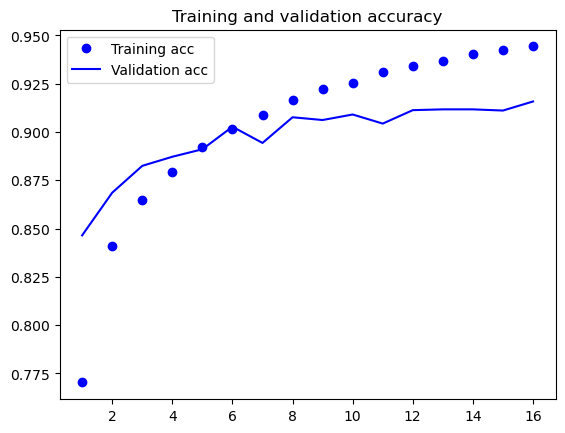

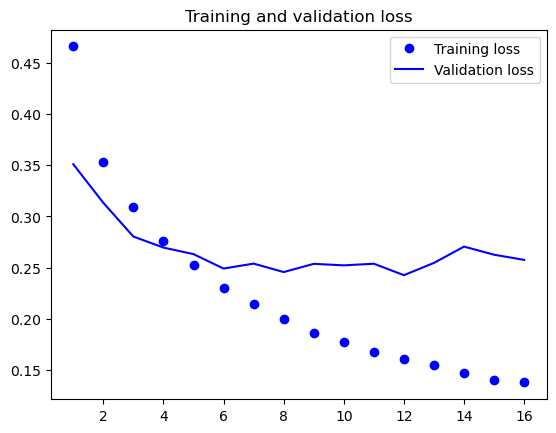

In [125]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Evaluating the model**

In [127]:
print ('\nTest')
test_loss, test_acc = model.evaluate(test_X, test_y)
print(f'test accuracy: {test_acc:.4f}')


Test
623/623 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9164 - loss: 0.2169
test accuracy: 0.9012


**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred=model.predict(test_X)
y_pred_classes =(y_pred > 0.5)
confmat=confusion_matrix(test_y,y_pred_classes)
print(confmat)

### **Test Result Log**

| Dropout Rate (D) | Accuracy | Epochs | Notes                                              | Tester         | Input Data % | Conv Layers | DenseLayers| size|
|------------------|----------|--------|----------------------------------------------------|----------------|--------------|-------------|------------|-----|
| –                | 0.8127   | 10     | testing if different sizes make a diffrence.  | Emma   | 30%                  | 2          | 1     | 64 X 64|     
| 0.55             | 0.8180| 10     | Significant improvement after increasing dataset.  | Emma          | 30%          | 2          | 100 X 100           |
| 0.55             |0.8173| 10     | Slight improvement observed with 0.55 dropout.     | Emma          | 30%          | 2           | 100 X 100           |
| 0.4              | 0.8138   | 10     | Matched performance. Is this a good thing?         | Emma          | 96%          | 2          | 128X128          |
| 0.3              | 0.8185   | 10     | Slight dip at lower dropout.                       | Emma          | 96%          | 129 dense layer          | 1           |
| 0.55             | 0.9004   | 7      | Fewer epochs didn’t improve accuracy.              | Emma           | 96%          | 2          | 1          |
